In [26]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [27]:
import datetime
import time
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd

from funcs.tse import get_ticker_name_list
from modules.psar import RealtimePSAR

In [28]:
pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\.xlsx")

In [29]:
name_excel = "../excel/tick_20250620.xlsx"
ticker = "7011"
#ticker = "7203"
#ticker = "8306"

m = pattern.match(name_excel)
if m:
    year = m.group(1)
    month = m.group(2)
    day = m.group(3)
else:
    year = "1970"
    month = "01"
    day = "01"
date_str = f"{year}-{month}-{day}"
df = pd.read_excel(name_excel, sheet_name=ticker)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
df

,Time,Price
2025-06-20 09:00:03.283561,1.750378e+09,3524
2025-06-20 09:00:04.294989,1.750378e+09,3524
2025-06-20 09:00:05.324481,1.750378e+09,3534
2025-06-20 09:00:06.332111,1.750378e+09,3534
2025-06-20 09:00:07.329522,1.750378e+09,3530
...,...,...
2025-06-20 15:24:55.589396,1.750401e+09,3459
2025-06-20 15:24:56.580169,1.750401e+09,3459
2025-06-20 15:24:57.582748,1.750401e+09,3459
2025-06-20 15:24:58.584463,1.750401e+09,3460


In [30]:
td = datetime.timedelta(minutes=20)
dt_max = df.index[0] + td
df = df[df.index <= dt_max]

In [31]:
def get_psar(df: pd.DataFrame):
    rpsar = RealtimePSAR()
    df_psar = pd.DataFrame({
        "Price": [],
        "Trend": [],
        "PSAR": []
    })
    for t in df.index:
        y = df.at[t, "Price"]
        ret = rpsar.add(y)
        df_psar.at[t, "Price"] = y
        df_psar.at[t, "Trend"] = ret.trend
        df_psar.at[t, "PSAR"] = ret.psar
    ser_bull = df_psar[df_psar["Trend"] > 0]["PSAR"]
    ser_bear = df_psar[df_psar["Trend"] < 0]["PSAR"]
    return ser_bull, ser_bear

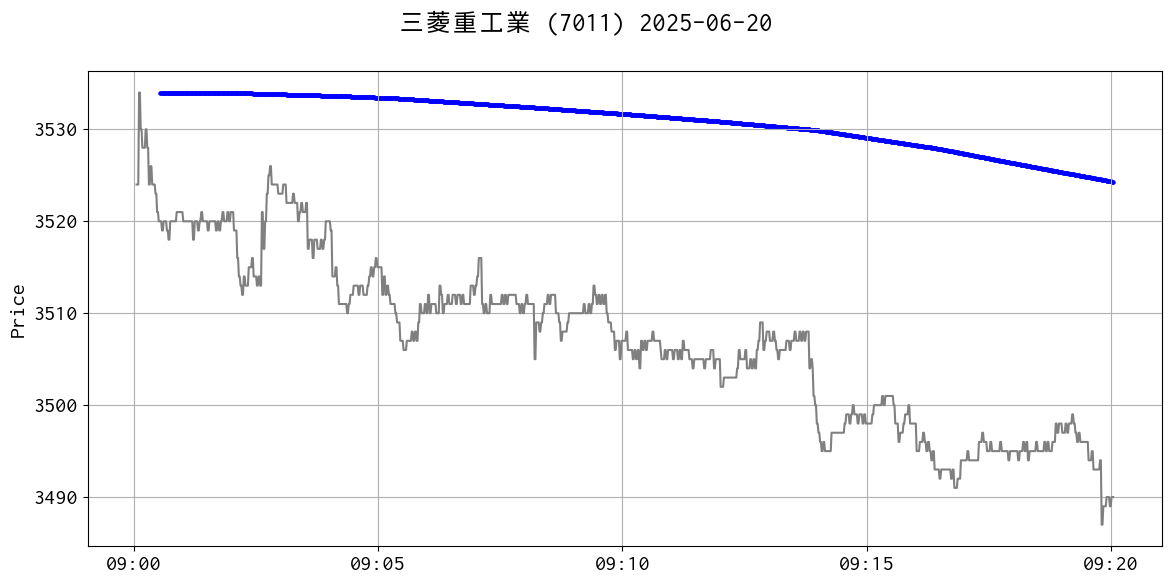

In [32]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(figsize=(12, 6))
ax.grid()
    

df_med = pd.DataFrame(df["Price"].rolling(3, min_periods=1).median())
ax.plot(df_med, color="gray")
ser_bull, ser_bear = get_psar(df_med)
ax.scatter(x=ser_bull.index, y=ser_bull, s=5, c="red")
ax.scatter(x=ser_bear.index, y=ser_bear, s=5, c="blue")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel(f"Price")

dict_name = get_ticker_name_list([ticker])
plt.suptitle(f"{dict_name[ticker]} ({ticker}) {date_str}")
plt.tight_layout()
plt.savefig(f"screenshots/psar_first_entry_{ticker}_{date_str}_{int(time.time())}.png" )
plt.show()